# Setup

**Imports**

In [ ]:
!pip install loadmydata

In [ ]:
import numpy as np
from scipy.signal import argrelmax
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

In [ ]:
THRESHOLD_IoU = 0.75

**Utility functions**

In [ ]:
def _check_step_list(step_list):
    """Some sanity checks."""
    for step in step_list:
        assert len(step) == 2, f"A step consists of a start and an end: {step}."
        start, end = step
        assert start < end, f"start should be before end: {step}."

In [ ]:
def inter_over_union(interval_1, interval_2):
    """Intersection over union for two intervals."""
    a, b = interval_1
    c, d = interval_2
    intersection = max(0, min(b, d) - max(a, c))
    if intersection > 0:
        union = max(b, d) - min(a, c)
    else:
        union = (b - a) + (d - c)
    return intersection / union

In [ ]:
def _step_detection_precision(step_list_true, step_list_pred):
    """Precision is the number of correctly predicted steps divided by the number of predicted
    steps. A predicted step is counted as correct if it overlaps an annotated step (measured by the
    "intersection over union" metric) by more than 75%.
    Note that an annotated step can only be detected once. If several predicted steps correspond
    to the same annotated step, all but one are considered as false.
    Here, precision is computed on a single prediction task (all steps correspond to the same
    signal).
    The lists y_true_ and y_pred are lists of steps, for instance:
        - step_list_true: [[357, 431], [502, 569], [633, 715], [778, 849], [907, 989]]
        - step_list_pred: [[293, 365], [422, 508], [565, 642], [701, 789]]
    Arguments:
        step_list_true {List} -- list of true steps
        step_list_pred {List} -- list of predicted steps
    Returns:
        float -- precision, between 0.0 and 1.0
    """
    _check_step_list(step_list_pred)

    if len(step_list_pred) == 0:  # empty prediction
        return 0.0

    n_correctly_predicted = 0
    detected_index_set = set()  # set of index of detected true steps
    for step_pred in step_list_pred:
        for (index, step_true) in enumerate(step_list_true):
            if (index not in detected_index_set) and (
                inter_over_union(step_pred, step_true) > THRESHOLD_IoU
            ):
                n_correctly_predicted += 1
                detected_index_set.add(index)
                break
    return n_correctly_predicted / len(step_list_pred)

In [ ]:
def _step_detection_recall(step_list_true, step_list_pred):
    """Recall is the number of detected annotated steps divided by the total number of annotated
    steps. An annotated step is counted as detected if it overlaps a predicted step (measured by
    the "intersection over union" metric) by more than 75%.
    Note that an annotated step can only be detected once. If several annotated steps are detected
    with the same predicted step, all but one are considered undetected.
    Here, recall is computed on a single prediction task (all steps correspond to the same
    signal).
    The lists y_true_ and y_pred are lists of steps, for instance:
        - step_list_true: [[357, 431], [502, 569], [633, 715], [778, 849], [907, 989]]
        - step_list_pred: [[293, 365], [422, 508], [565, 642], [701, 789]]
    Arguments:
        step_list_true {List} -- list of true steps
        step_list_pred {List} -- list of predicted steps
    Returns:
        float -- recall, between 0.0 and 1.0
    """
    _check_step_list(step_list_pred)

    n_detected_true = 0
    predicted_index_set = set()  # set of indexes of predicted steps

    for step_true in step_list_true:
        for (index, step_pred) in enumerate(step_list_pred):
            if (index not in predicted_index_set) and (
                inter_over_union(step_pred, step_true) > THRESHOLD_IoU
            ):
                n_detected_true += 1
                predicted_index_set.add(index)
                break
    return n_detected_true / len(step_list_true)

In [ ]:
def f1_score_step_detection(y_true, y_pred) -> float:
    """
    Calculate f-score (geometric mean between precision and recall) for each instance (each
    signal) and return the weighted average over instances.
    The lists y_true_ and y_pred are lists of lists of steps, for instance:
        - y_true: [[[907, 989]] [[357, 431], [502, 569]], [[633, 715], [778, 849]]]
        - y_pred: [[[293, 365]], [[422, 508], [565, 642]], [[701, 789]]]
    Arguments:
        y_true {List} -- true steps
        y_pred {List} -- predicted steps
    Returns:
        float -- f-score, between 0.0 and 1.0
    """
    # to prevent throwing an exception when passing empty lists
    if len(y_true) == 0:
        return 0

    fscore_list = list()

    for (step_list_true, step_list_pred) in zip(y_true, y_pred):
        prec = _step_detection_precision(step_list_true, step_list_pred)
        rec = _step_detection_recall(step_list_true, step_list_pred)
        if prec + rec < 1e-6:
            fscore_list.append(0.0)
        else:
            fscore_list.append((2 * prec * rec) / (prec + rec+0.0001))

    return np.mean(fscore_list)

In [ ]:
def sparsify_codes(z_1D, atom_length: int):
    """Set to zero codes that are too close to each others.
    
    Keep only the (local) maximum code and set to zero codes that are less than
    `atom_length` away.
    `z_1D` is assumed to be univariate.
    """
    res = np.zeros_like(z_1D)
    argmax_indexes, = argrelmax(z_1D, order=atom_length)
    res[argmax_indexes] = z_1D[argmax_indexes]
    return res


def sparse_codes_to_list_of_steps(z_1D, atom_length: int):
    """Return a list of steps from a 1D activation vector."""
    z_1D_sparser = sparsify_codes(z_1D=z_1D, atom_length=atom_length)
    start_array, = np.nonzero(z_1D_sparser)
    end_array = start_array + atom_length
    return np.c_[start_array, end_array].tolist()

In [ ]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax
def plot_CDL(D, figsize=(7, 11)):
    """Plot the learned dictionary `D` and the associated sparse codes `Z`.

    `signal` is an univariate signal of shape (n_samples,) or (n_samples, 1).
    """
    
    
    
    (atom_length, n_atoms) = np.shape(D)
    fig, axes = plt.subplots(nrows=n_atoms, ncols=1, figsize=figsize)
    for i in range(n_atoms):
        axes[i].set_title(f'Atom{i+1}')
        axes[i].plot(D[:, i])
    fig.tight_layout()
    plt.show()

# Convolutional dictionary learning (CDL)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,

- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [ ]:
subset_indexes_train = [851, 428, 739, 621, 147, 281, 95, 619, 441, 149, 951, 803, 214, 754, 34, 516, 684, 514, 465, 675, 654, 665, 297, 217, 618, 37, 954, 888, 630, 839, 897, 146, 559, 896, 941, 93, 658, 674, 78, 498, 575, 525, 36, 313, 300, 710, 56, 460, 397, 943]
subset_indexes_test = [683, 259, 59, 387, 634, 611, 87, 201, 86, 849, 538, 962, 205, 15, 883, 42]

code_list = get_code_list()
X_train = list()  # list of signals
y_train = list()  # list of list of steps (the "labels")
list_of_pathologies_train = list()

X_test = list()  # list of signals
y_test = list()  # list of list of steps (the "labels")
list_of_pathologies_test = list()


for (X, y, list_of_pathologies, subset_indexes) in zip([X_train, X_test], [y_train, y_test], [list_of_pathologies_train, list_of_pathologies_test], [subset_indexes_train, subset_indexes_test]):
    for code in np.take(code_list, subset_indexes):
        
        single_trial = load_human_locomotion_dataset(code)
        signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
        steps = single_trial.left_steps
        X.append(signal[:2000])  # truncate signals to have the same length 
        y.append(steps[(steps<2000).prod(axis=1).astype(bool)])
        list_of_pathologies.append(single_trial.metadata["PathologyGroup"])
    
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

Display one signal. Notice the repetitive patterns: those are the footsteps to detect.

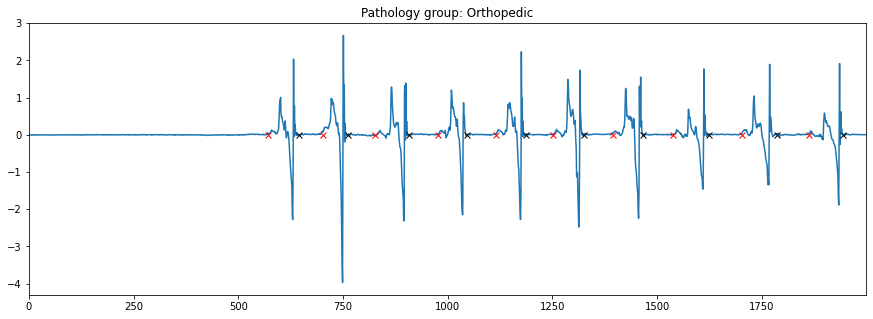

In [ ]:
ind = 5  # choose a signal
(signal, steps, pathology) = X_train[ind], y_train[ind], list_of_pathologies_train[ind]

ll=[]
lr=[]
ml=[]
mr=[]
for i in steps :
  ll.append(i[0])
  lr.append(i[1])
  ml.append(0)
  mr.append(0)
# plotting and saving the figure
fig, ax = fig_ax()
ax.plot(signal)
ax.plot(ll,ml,'x',color='red')
ax.plot(lr,mr,'x',color='black')



_ = ax.set_title(f"Pathology group: {pathology}")

## Question 3

In [ ]:
!pip install alphacsc

In [ ]:
from alphacsc import learn_d_z
from alphacsc.utils import construct_X

V_0/30 .............................
(5, 1, 1901)


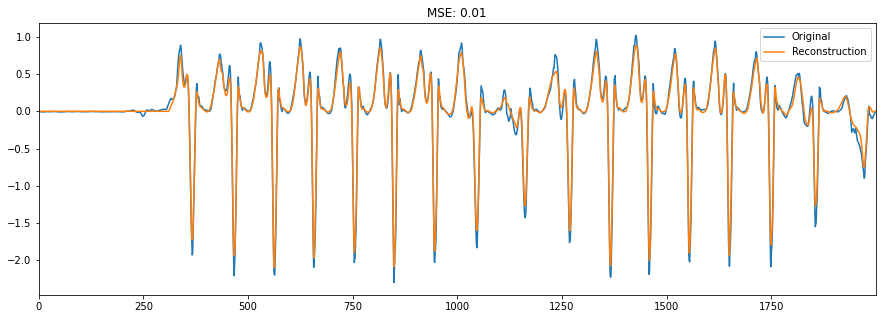

In [ ]:
ind = 45  # choose a signal
(signal, steps, pathology) = X_train[ind], y_train[ind], list_of_pathologies_train[ind]
### Change this part (at least)
n_atoms=5
atom_length=100
penalty=0.5
new_signal=signal[np.newaxis,:]
pobj, _, d_hat, z_hat, _ = learn_d_z(X=new_signal, n_atoms=n_atoms, n_times_atom=atom_length, reg=penalty, verbose=1, n_jobs=1, n_iter=30)
print(z_hat.shape)
reconstruction = construct_X(z_hat, d_hat).squeeze()
  # add your own reconstruction
mse = np.mean((signal - reconstruction)**2)

###

# plotting and saving the figure
fig, ax = fig_ax()
ax.set_title(f"MSE: {mse:.2f}")
ax.plot(signal, label="Original")
ax.plot(reconstruction, label="Reconstruction")
plt.legend()
# saving the figure
plt.savefig(fname="figure-question-3.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)

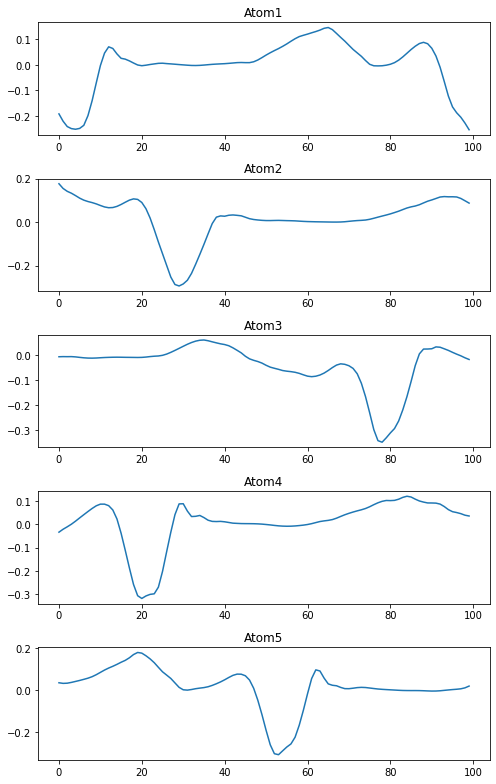

In [ ]:
plot_CDL(d_hat.T.squeeze())

## Question 4

Hints:
- For ease of use, code a scikit-learn estimator class `ConvDL` that implements 
    - `.fit()` (learn dictionary),
    - `.predict()` method (return a list of list of steps). Use the helper function `sparse_codes_to_list_of_steps`.
- In the cross-validation, use the `f1_score_step_detection` function to compute the F-score between prediction and label.

In [ ]:
from alphacsc import update_z, learn_d_z
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error

class ConvDL(BaseEstimator):
    def __init__(self, penalty, n_atoms, atom_length, n_iter=30,d_hat=None,z_hat=None):
        self.n_atoms=n_atoms
        self.atom_length=atom_length
        self.n_iter=n_iter
        self.penalty = penalty
        self.d_hat=d_hat
        self.z_hat=z_hat
        

    def fit(self, X, y=None):
        pobj, _, d_hat, _ , _ = learn_d_z(X=X, n_atoms=self.n_atoms, n_times_atom=self.atom_length, reg=self.penalty, verbose=1, n_jobs=12, n_iter=self.n_iter, lmbd_max="scaled")
        self.d_hat=d_hat
        return self
    
    def predict(self, X):
        if self.d_hat is None :
          self.fit(X)
        z_hat = update_z.update_z(X, self.d_hat, self.penalty)
        predicted_steps=[]
        for i in range(X.shape[0]):
            predicted_steps.append(sparse_codes_to_list_of_steps(np.sum(z_hat,axis=0)[i],self.atom_length))
        self.z_hat = z_hat
        return predicted_steps

    def get_params(self, deep=True):
        return {"penalty": self.penalty, 
                "n_atoms": self.n_atoms,
                "atom_length": self.atom_length,
                "n_iter":self.n_iter,
                "d_hat":self.d_hat,
                "z_hat":self.z_hat}


    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self




In [ ]:
Conv=ConvDL(penalty=penalty,n_atoms=n_atoms,atom_length=atom_length,n_iter=10)
predicted_steps = Conv.predict(X_train)
print(f1_score_step_detection(predicted_steps,y_train))

V_0/10 .........
0.015335321689894208


Use helper functions from scikit-learn to find the optimal combination of parameters.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# list of values for lambda as a percentage of lambda_max (see Question 2)
# use the argument `lmbd_max="scaled"` in alphacsc.learn_d_z 
penalty_list = [0.1, 0.2, 0.5, 0.8, 0.9, 0.95] #[0.5]

# list of values for K
n_atoms_list = [2, 4, 6, 8, 10, 20] #[4]#, 6, 8]#

# list of values for L
atom_length_list = [20 50, 80, 100, 150] # 100]#,

In [ ]:
# use X_train and y_train
score=make_scorer(f1_score_step_detection)
param_grid={"penalty" : penalty_list, "n_atoms" : n_atoms_list, "atom_length" : atom_length_list}
grid = GridSearchCV(estimator=Conv, param_grid=param_grid, scoring=score, cv=5, n_jobs=12,refit=True)
grid.fit(X_train,y_train)

V_0/10 .........


GridSearchCV(cv=5,
             estimator=ConvDL(atom_length=100,
                              d_hat=array([[-6.28147797e-02, -9.34051717e-02, -1.04818291e-01,
        -9.78545078e-02, -6.45094781e-02, -7.10414726e-03,
         1.31080887e-01,  1.60795420e-01, -8.45199389e-03,
         6.63070810e-03,  1.25799558e-01,  1.43959607e-01,
         1.33763995e-01,  1.24087786e-01,  1.08341054e-01,
         1.15661882e-01,  1.23721377e-01,  1.20349540e-01,
         1.309624...
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.04942822,
         0.05889065, 0.07486725],
       

In [ ]:
best_estimator=grid.best_estimator_
predicted_steps=best_estimator.predict(X_train)
Score = f1_score_step_detection(predicted_steps,y_train)
d_hat,z_hat=best_estimator.d_hat,best_estimator.z_hat

Mse_list=[]
for i in range(X_train.shape[0]):
    signal = X_train[i]
    reconstruction = construct_X(z_hat, d_hat).squeeze()
    mse = np.mean((signal - reconstruction)**2)
    Mse_list.append(mse)
MSE=np.mean(Mse_list)

#print("The best parameters are : " ,grid.best_params_)
print("The best average F-score is : ", Score)
print("The best MSE is : ",MSE)

The best average F-score is :  0.03367292460305097
The best MSE is :  0.21268941475602282


## Question 5

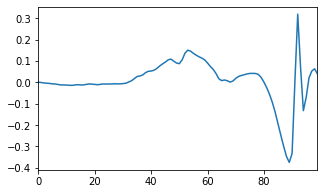

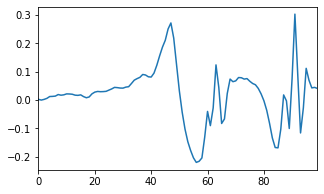

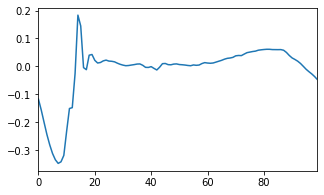

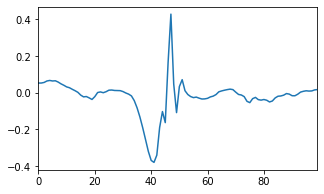

In [ ]:
# adapt this code to your variables
D=best_estimator.d_hat
dictionary = D  # add the learned dictionary

for (k, atom) in enumerate(dictionary):
    fig, ax = fig_ax(figsize=(5, 3))
    ax.plot(atom)
    # saving the figure
    plt.savefig(fname=f"figure-question-5-atom-{k}.pdf", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)

## Question 6

In [ ]:
# use X_test and y_test
f_scores=[]
y_pred_test=best_estimator.predict(X_test)
for i in range(X_test.shape[0]):
  
    f_scores.append(f1_score_step_detection([y_pred_test[i]],[y_test[i]]))
n_min = np.argmin(f_scores)
n_max = np.argmax(f_scores)
print(n_min)
print(n_max)






0
11


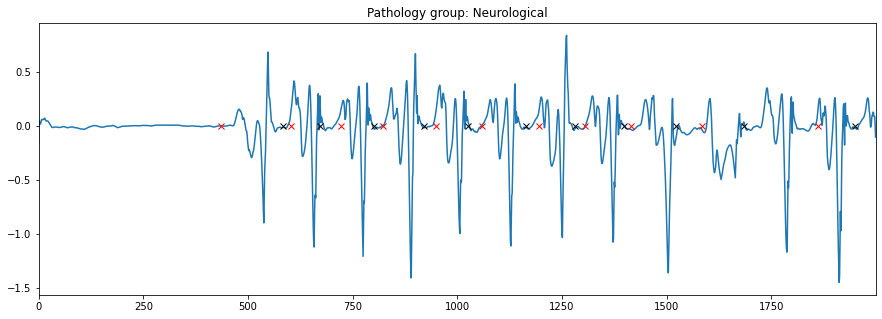

In [ ]:
(signal, steps, pathology) = X_test[n_min], y_test[n_min], list_of_pathologies_test[n_min]

ll=[]
lr=[]
ml=[]
mr=[]
for i in steps :
  ll.append(i[0])
  lr.append(i[1])
  ml.append(0)
  mr.append(0)
# plotting and saving the figure
fig, ax = fig_ax()
ax.plot(signal)
ax.plot(ll,ml,'x',color='red')
ax.plot(lr,mr,'x',color='black')


_ = ax.set_title(f"Pathology group: {pathology}")

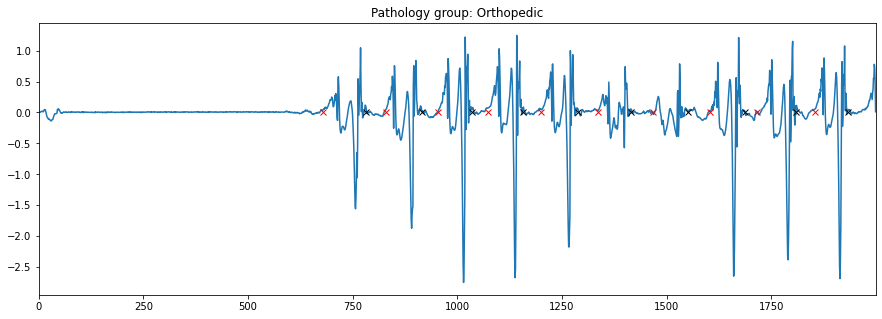

In [ ]:
(signal, steps, pathology) = X_test[n_max], y_test[n_max], list_of_pathologies_test[n_max]

ll=[]
lr=[]
ml=[]
mr=[]
for i in steps :
  ll.append(i[0])
  lr.append(i[1])
  ml.append(0)
  mr.append(0)
# plotting and saving the figure
fig, ax = fig_ax()
ax.plot(signal)
ax.plot(ll,ml,'x',color='red')
ax.plot(lr,mr,'x',color='black')


_ = ax.set_title(f"Pathology group: {pathology}")

# Dynamic time warping (DTW)

For this section, the data remain the same but the task is different. We want to classify footsteps in healthy/non-healthy (instead of detecting them as before).

## Data

In [ ]:
subset_indexes = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
code_list = get_code_list()

X = list()  # list of footstep signals
y = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X.append(signal[start:end])
        y.append(label)

In [ ]:
!pip install dtw-python

     |████████████████████████████████| 580 kB 8.5 MB/s 


In [ ]:
!pip install dtaidistance

     |████████████████████████████████| 1.1 MB 6.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for dtaidistance: filename=dtaidistance-2.3.5-cp37-cp37m-linux_x86_64.whl size=1601166 sha256=a95200a3b80a7954b0c045e7d18d356dd8c112dc9fa2f51cb02f5dd0f7c7f8e9
  Stored in directory: /root/.cache/pip/wheels/d3/c6/1f/333854c7a74d5a705297f5ef3adef8af6468ecd9dcfcc0f753
Successfully built dtaidistance


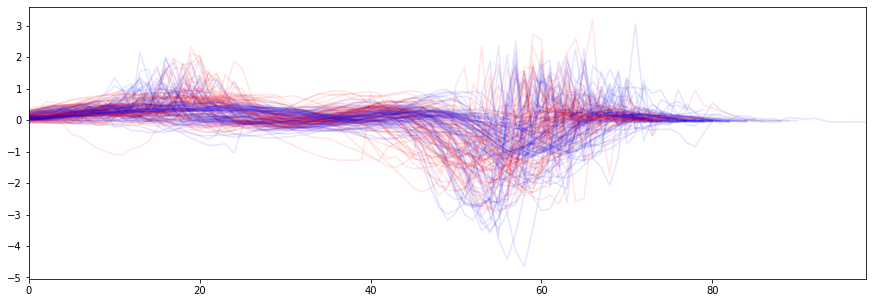

In [ ]:
fig, ax = fig_ax()
for (step_signal, label) in zip(X, y):
    color = "b" if label==0 else "r"
    ax.plot(step_signal, color=color, alpha=0.1)

## Question 7

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from dtw import dtw
from dtaidistance.dtw import distance_matrix_fast, distance
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [ ]:
X_copy,y_copy=shuffle(X,y,random_state=1)
ind=int(0.7*len(X_copy))
print(ind)

117


In [ ]:
X_train=X_copy[:ind]
X_val=X_copy[ind:]
y_train=y_copy[:ind]
y_val=y_copy[ind:]

In [ ]:
M=distance_matrix_fast(X_copy)

In [ ]:
M_train = M[:ind,:ind]
M_val = M[ind:,:ind]

In [ ]:
k_neighbors=KNeighborsClassifier()
neighbors=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_grid={"n_neighbors" : neighbors}
grid2 = GridSearchCV(k_neighbors, param_grid=param_grid, scoring='accuracy', cv=5,n_jobs=8,refit=True)
grid2.fit(M_train,y_train)
best_classifier = grid2.best_estimator_
print(grid2.best_params_)
print(grid2.best_score_)


{'n_neighbors': 3}
0.8369565217391303


## Question 8

In [ ]:
print("The accuracy is : ",np.sum(best_classifier.predict(M_val)==y_val)/len(y_val))

The accuracy is :  0.8627450980392157


In [ ]:
indices=np.where((best_classifier.predict(M_val)==y_val)==False)[0]
print("There are wrong predictions at : ",indices)
print("The labels at these indices are : ")
for i in indices :
  print("index = ",i, " and label = ",y_val[i])

There are wrong predictions at :  [ 9 15 20 21 23 26 31]
The labels at these indices are : 
index =  9  and label =  0
index =  15  and label =  0
index =  20  and label =  0
index =  21  and label =  1
index =  23  and label =  0
index =  26  and label =  1
index =  31  and label =  1


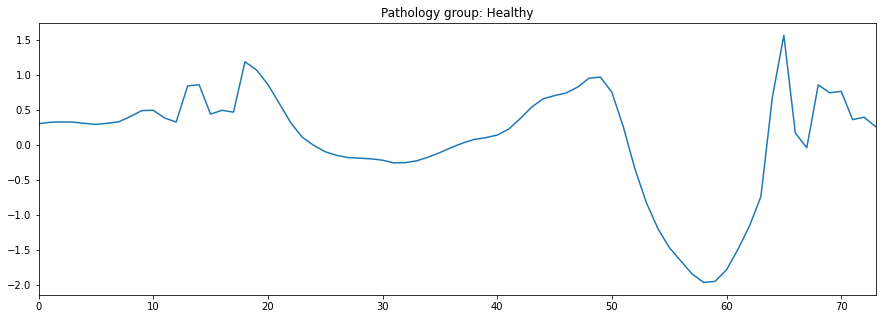

In [ ]:
(signal, steps, pathology) = X_val[20], y_val[20], "Healthy"

fig, ax = fig_ax()
ax.plot(signal)

_ = ax.set_title(f"Pathology group: {pathology}")

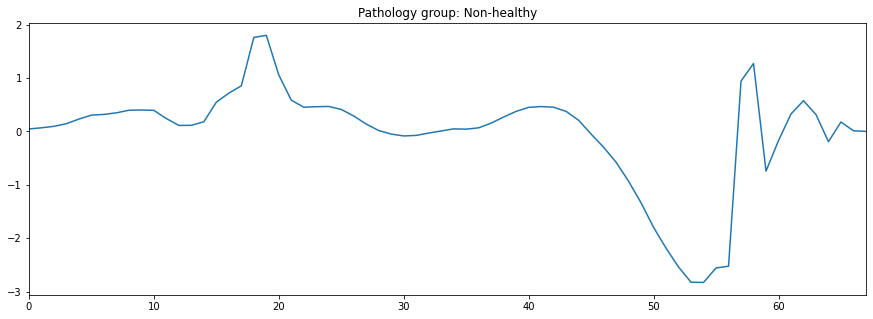

In [ ]:
(signal, steps, pathology) = X_val[21], y_val[21], "Non-healthy"

fig, ax = fig_ax()
ax.plot(signal)

_ = ax.set_title(f"Pathology group: {pathology}")